In [1]:
# HPC
import numpy as np
import xarray as xr
from scipy.interpolate import interp1d

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Paths and stuff
import os
import sys

import re
import warnings
warnings.filterwarnings("ignore")

sys.path.append('/home/shreyas/pySICOPOLIS/src')
from pySICOPOLIS import *

def extract_costs_from_file(filepath, iter_final):
    cost_list = []
    misfit_cost_list = []
    reg_cost_list = []

    pattern = re.compile(
        r"Iteration\s+\d+:\s+Cost\s+=\s+([0-9.]+),\s+Misfit Cost\s+=\s+([0-9.]+),\s+Regularization Cost\s+=\s+([0-9.]+)"
    )

    with open(filepath, 'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                cost, misfit, reg = map(float, match.groups())
                cost_list.append(cost)
                misfit_cost_list.append(misfit)
                reg_cost_list.append(reg)

    return cost_list[:iter_final + 1], misfit_cost_list[:iter_final + 1], reg_cost_list[:iter_final + 1]

In [15]:
np.max(ds_surfvel_model_40km_nottuned["cell_area"].data)/np.min(ds_surfvel_model_40km_nottuned["cell_area"].data)

1.1700163

In [2]:
modelPath = '/home/shreyas/update_to_develop_sicopolis/sicopolis_spinups/sico_out/'
dataPath = '/scratch2/shreyas/GrIS_paleo_data/'

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data_40_orig = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms_orig.nc")
ds_surfvel_data_40km = xr.open_dataset(dataPath + 'surfvel_data_40kms.nc')
ds_surfvel_model_40km_nottuned = xr.open_dataset(modelPath + 'grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp/grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp0007.nc')

H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

vs_orig_data = ds_surfvel_data_40km["vs_orig"].data
vs_data = ds_surfvel_data_40km["vs"].data
vx_data = ds_surfvel_data_40km["vx"].data
vy_data = ds_surfvel_data_40km["vy"].data

# Cost function is the sum of 2 ratios, each of which is 1/2*(non-zero data), so total should be 1.0*(non-zero data)
one_sigma_threshold = np.sum(vs_data != 0.0)

vs_model_nottuned = (ds_surfvel_model_40km_nottuned['vx_s_g'].data**2 + ds_surfvel_model_40km_nottuned['vy_s_g'].data**2)**0.5
vx_model_nottuned = ds_surfvel_model_40km_nottuned['vx_s_g'].data
vy_model_nottuned = ds_surfvel_model_40km_nottuned['vy_s_g'].data

mask_land = ds_surfvel_model_40km_nottuned["mask"].data.copy()
mask_land[mask_land == 0] = -1
mask_land[mask_land == 1] = -1
mask_land[mask_land == 2] = 1
mask_land[mask_land == 3] = 1

mask_ice = ds_surfvel_model_40km_nottuned["mask"].data.copy()
mask_ice[mask_ice == 0] = -1
mask_ice[mask_ice == 3] = -1
mask_ice[mask_ice == 1] = 1
mask_ice[mask_ice == 2] = 1

In [3]:
def uncert_analysis(scale):
    data_uncert_x = ds_surfvel_data_40km["vx_uncert_unbounded"].data
    data_uncert_y = ds_surfvel_data_40km["vy_uncert_unbounded"].data
    
    model_uncert_notscaled_x = np.abs(ds_surfvel_data_40km["vx"].data)
    model_uncert_notscaled_y = np.abs(ds_surfvel_data_40km["vy"].data)
    
    total_uncert_notscaled_x = (model_uncert_notscaled_x**2 + data_uncert_x**2)**0.5
    total_uncert_notscaled_y = (model_uncert_notscaled_y**2 + data_uncert_y**2)**0.5
    
    factor = 1 - np.abs(H_data_40_orig["H"].data/np.max(H_data_40_orig["H"].data))*(scale/100.0)
    model_uncert_x = factor*np.abs(ds_surfvel_data_40km["vx"].data)
    model_uncert_y = factor*np.abs(ds_surfvel_data_40km["vy"].data)
    
    total_uncert_x = ds_surfvel_data_40km[f"vx_uncert_{scale}"].data
    total_uncert_y = ds_surfvel_data_40km[f"vy_uncert_{scale}"].data
    
    n_rows, n_cols = 7, 2
    aspect_ratio = len(ds_surfvel_model_40km_nottuned['x'])/len(ds_surfvel_model_40km_nottuned['y'])
    subplot_width = 4
    subplot_height = subplot_width / aspect_ratio
    plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
    fig, ax = plt.subplots(n_rows, n_cols)
    
    for axis in ax.flatten():
        axis.set_box_aspect(1/aspect_ratio)
        
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          data_uncert_x,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[0, 0],
                          cbar_label = "data_uncert_x")
    ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[0, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[0, 0].set_title("data_uncert_x")
    
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          data_uncert_y,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[0, 1],
                          cbar_label = "data_uncert_y")
    ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[0, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[0, 1].set_title("data_uncert_y")
    
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          model_uncert_notscaled_x,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[1, 0],
                          cbar_label = "model_uncert_notscaled_x")
    ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[1, 0].set_title("model_uncert_notscaled_x")
    
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          model_uncert_notscaled_y,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[1, 1],
                          cbar_label = "model_uncert_notscaled_y")
    ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[1, 1].set_title("model_uncert_notscaled_y")
    
    fancyPlotter.plot_normal(ds_surfvel_data_40km['x'], 
                             ds_surfvel_data_40km['y'], 
                             data_uncert_x > model_uncert_notscaled_x,
                             cmap = 'RdBu_r', nbins = 100, vmin = 0, vmax = 1,
                             fig = fig, ax = ax[2, 0],
                             cbar_label = "flag")
    ax[2, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[2, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[2, 0].set_title("data_uncert_x > model_uncert_notscaled_x")
    
    fancyPlotter.plot_normal(ds_surfvel_data_40km['x'], 
                             ds_surfvel_data_40km['y'], 
                             data_uncert_y > model_uncert_notscaled_y,
                             cmap = 'RdBu_r', nbins = 100, vmin = 0, vmax = 1,
                             fig = fig, ax = ax[2, 1],
                             cbar_label = "flag")
    ax[2, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[2, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[2, 1].set_title("data_uncert_y > model_uncert_notscaled_y")
    
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          total_uncert_notscaled_x,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[3, 0],
                          cbar_label = "total_uncert_notscaled_x")
    ax[3, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[3, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[3, 0].set_title("total_uncert_notscaled_x")
    
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          total_uncert_notscaled_y,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[3, 1],
                          cbar_label = "total_uncert_notscaled_y")
    ax[3, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[3, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[3, 1].set_title("total_uncert_notscaled_y")
    
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          model_uncert_x,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[4, 0],
                          cbar_label = "model_uncert_x")
    ax[4, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[4, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[4, 0].set_title("model_uncert_x")
    
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          model_uncert_y,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[4, 1],
                          cbar_label = "model_uncert_y")
    ax[4, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[4, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[4, 1].set_title("model_uncert_y")
    
    fancyPlotter.plot_normal(ds_surfvel_data_40km['x'], 
                             ds_surfvel_data_40km['y'], 
                             data_uncert_x > model_uncert_x,
                             cmap = 'RdBu_r', nbins = 100, vmin = 0, vmax = 1,
                             fig = fig, ax = ax[5, 0],
                             cbar_label = "flag")
    ax[5, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[5, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[5, 0].set_title("data_uncert_x > model_uncert_x")
    
    fancyPlotter.plot_normal(ds_surfvel_data_40km['x'], 
                             ds_surfvel_data_40km['y'], 
                             data_uncert_y > model_uncert_y,
                             cmap = 'RdBu_r', nbins = 100, vmin = 0, vmax = 1,
                             fig = fig, ax = ax[5, 1],
                             cbar_label = "flag")
    ax[5, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[5, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[5, 1].set_title("data_uncert_y > model_uncert_y")
    
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          total_uncert_x,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[6, 0],
                          cbar_label = "total_uncert_x")
    ax[6, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[6, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[6, 0].set_title("total_uncert_x")
    
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          total_uncert_y,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[6, 1],
                          cbar_label = "total_uncert_y")
    ax[6, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[6, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[6, 1].set_title("total_uncert_y")

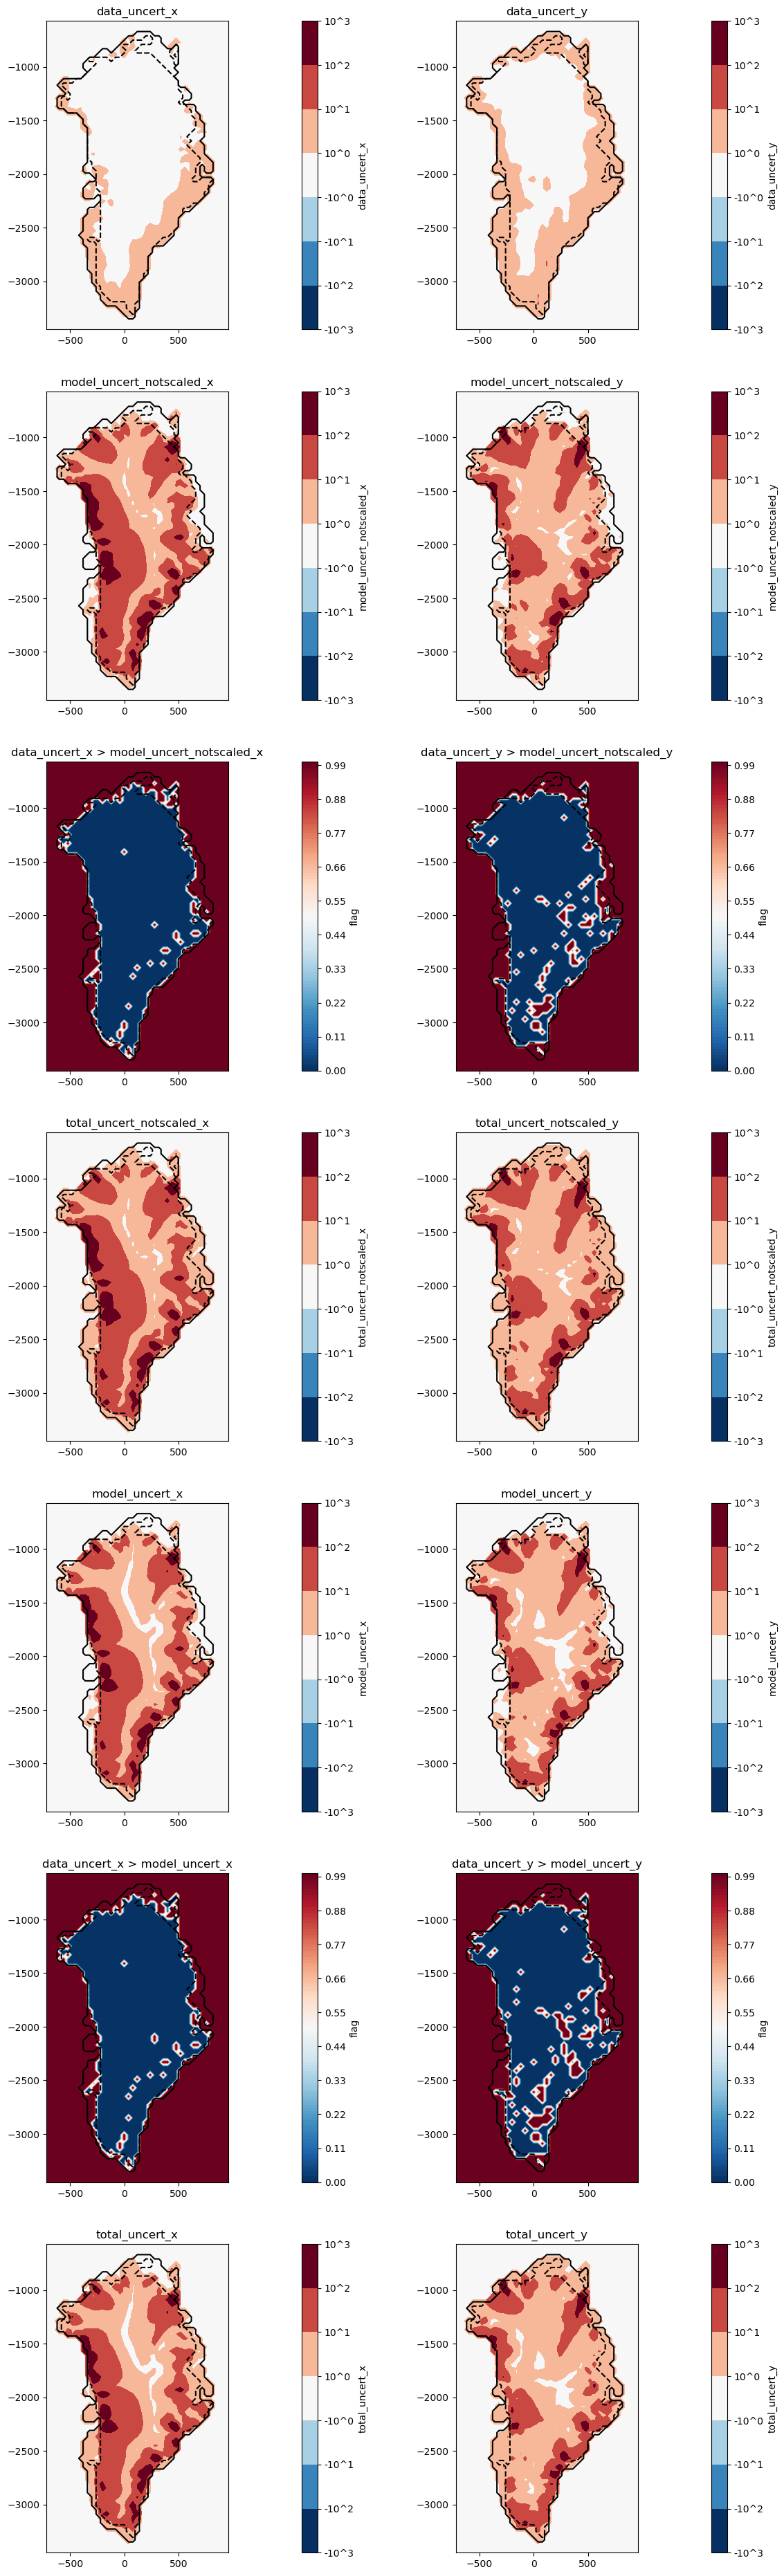

In [4]:
uncert_analysis(50)

In [9]:
def plotting(scale, suffix, iter_final, bool_pickup = False, iter_final_og_pickup = None, len_str_trunc_pickup = 7):

    ds_surfvel_model_tuned_40km = xr.open_dataset(f"/home/shreyas/update_to_develop_sicopolis/sicopolis_optim_SVC_{scale}{suffix}/sico_out/N_grl40_bm5_paleo17a_nudged_CT4_BH0_SVC_m21ka_pkp/0007.nc")

    if not bool_pickup:
        ds_init = xr.open_dataset(f"/scratch2/shreyas/optim_SVC_{scale}{suffix}/inexact_gn_hessian_cg/state_GNHessCG_iter_0.nc")
    else:
        # remove _pickup or _pickup_2 from suffix by using suffix[:-len_str_trunc_pickup]
        ds_init = xr.open_dataset(f"/scratch2/shreyas/optim_SVC_{scale}{suffix[:-len_str_trunc_pickup]}/inexact_gn_hessian_cg/state_GNHessCG_iter_0.nc")
    ds_final = xr.open_dataset(f"/scratch2/shreyas/optim_SVC_{scale}{suffix}/inexact_gn_hessian_cg/state_GNHessCG_iter_{iter_final}.nc")

    vs_model_tuned = (ds_surfvel_model_tuned_40km['vx_s_g'].data**2 + ds_surfvel_model_tuned_40km['vy_s_g'].data**2)**0.5
    vx_model_tuned = ds_surfvel_model_tuned_40km['vx_s_g'].data
    vy_model_tuned = ds_surfvel_model_tuned_40km['vy_s_g'].data

    if not bool_pickup:
        costs, misfits, regs = extract_costs_from_file(f"/scratch2/shreyas/optim_SVC_{scale}{suffix}/inexact_gn_hessian_cg/inexact_gn_hessian_cg.log", iter_final)
    else:
        # iter_final_og_pickup - 1 cuz the cost will be same for iter 0 of pickup
        costs, misfits, regs = extract_costs_from_file(f"/scratch2/shreyas/optim_SVC_{scale}{suffix[:-len_str_trunc_pickup]}/inexact_gn_hessian_cg/inexact_gn_hessian_cg.log", iter_final_og_pickup - 1)
        costs_pickup, misfits_pickup, regs_pickup = extract_costs_from_file(f"/scratch2/shreyas/optim_SVC_{scale}{suffix}/inexact_gn_hessian_cg/inexact_gn_hessian_cg.log", iter_final)
        costs = costs + costs_pickup
        misfits = misfits + misfits_pickup
        regs = regs + regs_pickup
    
    n_rows, n_cols = 7, 5
    aspect_ratio = len(ds_surfvel_model_40km_nottuned['x'])/len(ds_surfvel_model_40km_nottuned['y'])
    subplot_width = 4
    subplot_height = subplot_width / aspect_ratio
    plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
    fig, ax = plt.subplots(n_rows, n_cols)
    
    for axis in ax.flatten()[2:]:
        axis.set_box_aspect(1/aspect_ratio)
    
    ax[0, 0].plot(np.arange(len(costs)), costs / one_sigma_threshold, marker="o")
    ax[0, 0].plot(np.arange(len(misfits)), misfits / one_sigma_threshold, marker="o")
    ax[0, 0].axhline(1.0, color = "red")
    ax[0, 0].set_title("Normalized cost vs iterations")

    ax[0, 1].plot(regs / one_sigma_threshold, misfits / one_sigma_threshold, marker="o")
    ax[0, 1].set_title("Normalized misfit cost vs Normalized regularization cost")
        
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          vs_data,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[0, 2],
                          cbar_label = "vs data")
    ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[0, 2].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[0, 2].set_title("vs MEaSUREs data")
    
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          vx_data,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[0, 3],
                          cbar_label = "vx data")
    ax[0, 3].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[0, 3].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[0, 3].set_title("vx MEaSUREs data")
    
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          vy_data,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[0, 4],
                          cbar_label = "vy data")
    ax[0, 4].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[0, 4].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[0, 4].set_title("vy MEaSUREs data")
    
    fancyPlotter.plot_normal(ds_surfvel_data_40km['x'], 
                            ds_surfvel_data_40km['y'], 
                            10**ds_init["xx_c_slide_init"].data,
                            cmap = 'RdBu_r', nbins = 100, vmin = 0, vmax = 1.7,
                            fig = fig, ax = ax[1, 0],
                            cbar_label = "Basal sliding coefficient")
    ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[1, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[1, 0].set_title("Basal sliding coefficient not tuned")
    
    fancyPlotter.plot_normal(ds_surfvel_data_40km['x'], 
                            ds_surfvel_data_40km['y'], 
                            10**ds_init["xx_q_geo"].data,
                            cmap = 'jet', nbins = 100, vmin = 0.0, vmax = 0.15,
                            fig = fig, ax = ax[1, 1],
                            cbar_label = "Geothermal heat flux")
    ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[1, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[1, 1].set_title("Geothermal heat flux not tuned")
    
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          vs_model_nottuned,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[1, 2],
                          cbar_label = "vs model")
    ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[1, 2].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[1, 2].set_title("vs model not tuned")
    
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          vx_model_nottuned,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[1, 3],
                          cbar_label = "vx model")
    ax[1, 3].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[1, 3].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[1, 3].set_title("vx model not tuned")
    
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          vy_model_nottuned,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[1, 4],
                          cbar_label = "vy model")
    ax[1, 4].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[1, 4].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[1, 4].set_title("vy model not tuned")
    
    fancyPlotter.plot_normal(ds_surfvel_data_40km['x'], 
                            ds_surfvel_data_40km['y'], 
                            10**ds_final["xx_c_slide_init"].data,
                            cmap = 'RdBu_r', nbins = 100, vmin = 0, vmax = 1.7,
                            fig = fig, ax = ax[2, 0],
                            cbar_label = "Basal sliding coefficient")
    ax[2, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[2, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[2, 0].set_title("Basal sliding coefficient tuned")
    
    fancyPlotter.plot_normal(ds_surfvel_data_40km['x'], 
                            ds_surfvel_data_40km['y'], 
                            10**ds_final["xx_q_geo"].data,
                            cmap = 'jet', nbins = 100, vmin = 0.0, vmax = 0.15,
                            fig = fig, ax = ax[2, 1],
                            cbar_label = "Geothermal heat flux")
    ax[2, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[2, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[2, 1].set_title("Geothermal heat flux tuned")
    
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          vs_model_tuned,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[2, 2],
                          cbar_label = "vs model")
    ax[2, 2].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[2, 2].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[2, 2].set_title("vs model tuned")
    
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          vx_model_tuned,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[2, 3],
                          cbar_label = "vx model")
    ax[2, 3].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[2, 3].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[2, 3].set_title("vx model tuned")
    
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          vy_model_tuned,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[2, 4],
                          cbar_label = "vy model")
    ax[2, 4].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[2, 4].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[2, 4].set_title("vy model tuned")
    
    fancyPlotter.plot_normal(ds_surfvel_data_40km['x'], 
                            ds_surfvel_data_40km['y'], 
                            10**ds_final["xx_c_slide_init"].data - 10**ds_init["xx_c_slide_init"].data,
                            cmap = 'RdBu_r', nbins = 100, vmin = -0.85, vmax = 0.85,
                            fig = fig, ax = ax[3, 0],
                            cbar_label = "Basal sliding coefficient")
    ax[3, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[3, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[3, 0].set_title("Difference b/w tuned and not tuned")
    
    fancyPlotter.plot_normal(ds_surfvel_data_40km['x'], 
                            ds_surfvel_data_40km['y'], 
                            10**ds_final["xx_q_geo"].data - 10**ds_init["xx_q_geo"].data,
                            cmap = 'RdBu_r', nbins = 100, vmin = -0.1, vmax = 0.1,
                            fig = fig, ax = ax[3, 1],
                            cbar_label = "Geothermal heat flux")
    ax[3, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[3, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[3, 1].set_title("Difference b/w tuned and not tuned")
    
    fancyPlotter.plot_normal(ds_surfvel_data_40km['x'], 
                             ds_surfvel_data_40km['y'], 
                             vs_model_nottuned/vs_data - 1,
                             cmap = 'RdBu_r', nbins = 100, vmin = -5, vmax = 5,
                             fig = fig, ax = ax[3, 2],
                             cbar_label = "vs model")
    ax[3, 2].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[3, 2].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[3, 2].set_title("Rel. difference b/w not tuned and data")
    
    fancyPlotter.plot_normal(ds_surfvel_data_40km['x'], 
                             ds_surfvel_data_40km['y'], 
                             (vx_model_nottuned/vx_data - 1)*(np.abs(vx_data) > 1.0),
                             cmap = 'RdBu_r', nbins = 100, vmin = -5, vmax = 5,
                             fig = fig, ax = ax[3, 3],
                             cbar_label = "vx model")
    ax[3, 3].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[3, 3].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[3, 3].set_title("Rel. difference b/w not tuned and data")

    field = (vy_model_nottuned/vy_data - 1)*(np.abs(vy_data) > 1.0)
    fancyPlotter.plot_normal(ds_surfvel_data_40km['x'], 
                             ds_surfvel_data_40km['y'], 
                             np.clip(field, -100, 100),
                             cmap = 'RdBu_r', nbins = 100, vmin = -5, vmax = 5,
                             fig = fig, ax = ax[3, 4],
                             cbar_label = "vy model")
    ax[3, 4].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[3, 4].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[3, 4].set_title("Rel. difference b/w not tuned and data")
    
    fancyPlotter.plot_normal(ds_surfvel_data_40km['x'], 
                            ds_surfvel_data_40km['y'], 
                            10**ds_final["xx_c_slide_init"].data / 10**ds_init["xx_c_slide_init"].data - 1,
                            cmap = 'RdBu_r', nbins = 100, vmin = -1.0, vmax = 1.0,
                            fig = fig, ax = ax[4, 0],
                            cbar_label = "Basal sliding coefficient")
    ax[4, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[4, 0].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[4, 0].set_title("Rel. difference b/w tuned and not tuned")
    
    fancyPlotter.plot_normal(ds_surfvel_data_40km['x'], 
                            ds_surfvel_data_40km['y'], 
                            10**ds_final["xx_q_geo"].data / 10**ds_init["xx_q_geo"].data - 1,
                            cmap = 'RdBu_r', nbins = 100, vmin = -1.0, vmax = 1.0,
                            fig = fig, ax = ax[4, 1],
                            cbar_label = "Geothermal heat flux")
    ax[4, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[4, 1].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[4, 1].set_title("Rel. difference b/w tuned and not tuned")
    
    fancyPlotter.plot_normal(ds_surfvel_data_40km['x'], 
                             ds_surfvel_data_40km['y'], 
                             vs_model_tuned/vs_data - 1,
                             cmap = 'RdBu_r', nbins = 100, vmin = -5, vmax = 5,
                             fig = fig, ax = ax[4, 2],
                             cbar_label = "vs model")
    ax[4, 2].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[4, 2].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[4, 2].set_title("Rel. difference b/w tuned and data")
    
    fancyPlotter.plot_normal(ds_surfvel_data_40km['x'], 
                             ds_surfvel_data_40km['y'], 
                             (vx_model_tuned/vx_data - 1)*(np.abs(vx_data) > 1.0),
                             cmap = 'RdBu_r', nbins = 100, vmin = -5, vmax = 5,
                             fig = fig, ax = ax[4, 3],
                             cbar_label = "vx model")
    ax[4, 3].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[4, 3].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[4, 3].set_title("Rel. difference b/w tuned and data")

    field = (vy_model_tuned/vy_data - 1)*(np.abs(vy_data) > 1.0)
    fancyPlotter.plot_normal(ds_surfvel_data_40km['x'], 
                             ds_surfvel_data_40km['y'], 
                             np.clip(field, -100, 100),
                             cmap = 'RdBu_r', nbins = 100, vmin = -5, vmax = 5,
                             fig = fig, ax = ax[4, 4],
                             cbar_label = "vy model")
    ax[4, 4].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[4, 4].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[4, 4].set_title("Rel. difference b/w tuned and data")

    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          vs_model_nottuned - vs_data,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[5, 2],
                          cbar_label = "vs model")
    ax[5, 2].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[5, 2].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[5, 2].set_title("Difference b/w not tuned and data")

    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          vx_model_nottuned - vx_data,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[5, 3],
                          cbar_label = "vx model")
    ax[5, 3].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[5, 3].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[5, 3].set_title("Difference b/w not tuned and data")

    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          vy_model_nottuned - vy_data,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[5, 4],
                          cbar_label = "vy model")
    ax[5, 4].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[5, 4].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[5, 4].set_title("Difference b/w not tuned and data")
    
    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          vs_model_tuned - vs_data,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[6, 2],
                          cbar_label = "vs model")
    ax[6, 2].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[6, 2].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[6, 2].set_title("Difference b/w tuned and data")

    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          vx_model_tuned - vx_data,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[6, 3],
                          cbar_label = "vx model")
    ax[6, 3].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[6, 3].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[6, 3].set_title("Difference b/w not tuned and data")

    fancyPlotter.plot_log(ds_surfvel_data_40km['x'], 
                          ds_surfvel_data_40km['y'], 
                          vy_model_tuned - vy_data,
                          cmap = 'RdBu_r', nbins = None, bin_edges = [0, 1, 2, 3], 
                          fig = fig, ax = ax[6, 4],
                          cbar_label = "vy model")
    ax[6, 4].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_land, levels=[0], colors="black")
    ax[6, 4].contour(ds_surfvel_data_40km['x'], 
                     ds_surfvel_data_40km['y'],
                     mask_ice, levels=[0], colors="black", linestyles = "dashed")
    ax[6, 4].set_title("Difference b/w not tuned and data")

    plt.tight_layout()

    print("MEAN")
    
    print(np.nansum(np.abs(vs_model_nottuned/vs_data - 1)*(vs_data != 0.0)) / np.nansum(vs_data != 0.0),
          np.nansum(np.abs(vx_model_nottuned/vx_data - 1)*(vx_data != 0.0)) / np.nansum(vx_data != 0.0),
          np.nansum(np.abs(vy_model_nottuned/vy_data - 1)*(vy_data != 0.0)) / np.nansum(vy_data != 0.0))

    print(np.nansum(np.abs(vs_model_nottuned/vs_data - 1)*(vs_data != 0.0)*(H_data <= 0.1*np.max(H_data))) / np.nansum((vs_data != 0.0)*(H_data <= 0.1*np.max(H_data))),
          np.nansum(np.abs(vx_model_nottuned/vx_data - 1)*(vx_data != 0.0)*(H_data <= 0.1*np.max(H_data))) / np.nansum((vx_data != 0.0)*(H_data <= 0.1*np.max(H_data))),
          np.nansum(np.abs(vy_model_nottuned/vy_data - 1)*(vy_data != 0.0)*(H_data <= 0.1*np.max(H_data))) / np.nansum((vy_data != 0.0)*(H_data <= 0.1*np.max(H_data))))

    print(np.nansum(np.abs(vs_model_nottuned/vs_data - 1)*(vs_data != 0.0)*(H_data >= 0.9*np.max(H_data))) / np.nansum((vs_data != 0.0)*(H_data >= 0.9*np.max(H_data))),
          np.nansum(np.abs(vx_model_nottuned/vx_data - 1)*(vx_data != 0.0)*(H_data >= 0.9*np.max(H_data))) / np.nansum((vx_data != 0.0)*(H_data >= 0.9*np.max(H_data))),
          np.nansum(np.abs(vy_model_nottuned/vy_data - 1)*(vy_data != 0.0)*(H_data >= 0.9*np.max(H_data))) / np.nansum((vy_data != 0.0)*(H_data >= 0.9*np.max(H_data))))
    
    print(np.nansum(np.abs(vs_model_tuned/vs_data - 1)*(vs_data != 0.0)) / np.nansum(vs_data != 0.0),
          np.nansum(np.abs(vx_model_tuned/vx_data - 1)*(vx_data != 0.0)) / np.nansum(vx_data != 0.0),
          np.nansum(np.abs(vy_model_tuned/vy_data - 1)*(vy_data != 0.0)) / np.nansum(vy_data != 0.0))

    print(np.nansum(np.abs(vs_model_tuned/vs_data - 1)*(vs_data != 0.0)*(H_data <= 0.1*np.max(H_data))) / np.nansum((vs_data != 0.0)*(H_data <= 0.1*np.max(H_data))),
          np.nansum(np.abs(vx_model_tuned/vx_data - 1)*(vx_data != 0.0)*(H_data <= 0.1*np.max(H_data))) / np.nansum((vx_data != 0.0)*(H_data <= 0.1*np.max(H_data))),
          np.nansum(np.abs(vy_model_tuned/vy_data - 1)*(vy_data != 0.0)*(H_data <= 0.1*np.max(H_data))) / np.nansum((vy_data != 0.0)*(H_data <= 0.1*np.max(H_data))))

    print(np.nansum(np.abs(vs_model_tuned/vs_data - 1)*(vs_data != 0.0)*(H_data >= 0.9*np.max(H_data))) / np.nansum((vs_data != 0.0)*(H_data >= 0.9*np.max(H_data))),
          np.nansum(np.abs(vx_model_tuned/vx_data - 1)*(vx_data != 0.0)*(H_data >= 0.9*np.max(H_data))) / np.nansum((vx_data != 0.0)*(H_data >= 0.9*np.max(H_data))),
          np.nansum(np.abs(vy_model_tuned/vy_data - 1)*(vy_data != 0.0)*(H_data >= 0.9*np.max(H_data))) / np.nansum((vy_data != 0.0)*(H_data >= 0.9*np.max(H_data))))

    print("MAX")

    print(np.nanmax(np.abs(vs_model_nottuned / vs_data - 1) * (vs_data != 0.0)),
          np.nanmax(np.abs(vx_model_nottuned / vx_data - 1) * (vx_data != 0.0)),
          np.nanmax(np.abs(vy_model_nottuned / vy_data - 1) * (vy_data != 0.0)))
    
    print(np.nanmax(np.abs(vs_model_nottuned / vs_data - 1) * (vs_data != 0.0) * (H_data <= 0.1 * np.max(H_data))),
          np.nanmax(np.abs(vx_model_nottuned / vx_data - 1) * (vx_data != 0.0) * (H_data <= 0.1 * np.max(H_data))),
          np.nanmax(np.abs(vy_model_nottuned / vy_data - 1) * (vy_data != 0.0) * (H_data <= 0.1 * np.max(H_data))))
    
    print(np.nanmax(np.abs(vs_model_nottuned / vs_data - 1) * (vs_data != 0.0) * (H_data >= 0.9 * np.max(H_data))),
          np.nanmax(np.abs(vx_model_nottuned / vx_data - 1) * (vx_data != 0.0) * (H_data >= 0.9 * np.max(H_data))),
          np.nanmax(np.abs(vy_model_nottuned / vy_data - 1) * (vy_data != 0.0) * (H_data >= 0.9 * np.max(H_data))))
    
    print(np.nanmax(np.abs(vs_model_tuned / vs_data - 1) * (vs_data != 0.0)),
          np.nanmax(np.abs(vx_model_tuned / vx_data - 1) * (vx_data != 0.0)),
          np.nanmax(np.abs(vy_model_tuned / vy_data - 1) * (vy_data != 0.0)))
    
    print(np.nanmax(np.abs(vs_model_tuned / vs_data - 1) * (vs_data != 0.0) * (H_data <= 0.1 * np.max(H_data))),
          np.nanmax(np.abs(vx_model_tuned / vx_data - 1) * (vx_data != 0.0) * (H_data <= 0.1 * np.max(H_data))),
          np.nanmax(np.abs(vy_model_tuned / vy_data - 1) * (vy_data != 0.0) * (H_data <= 0.1 * np.max(H_data))))
    
    print(np.nanmax(np.abs(vs_model_tuned / vs_data - 1) * (vs_data != 0.0) * (H_data >= 0.9 * np.max(H_data))),
          np.nanmax(np.abs(vx_model_tuned / vx_data - 1) * (vx_data != 0.0) * (H_data >= 0.9 * np.max(H_data))),
          np.nanmax(np.abs(vy_model_tuned / vy_data - 1) * (vy_data != 0.0) * (H_data >= 0.9 * np.max(H_data))))

    print("SCALARS")
    
    print(10**ds_final["xx_p_weert"].data[0]/10**ds_init["xx_p_weert"].data[0] - 1,
          10**ds_final["xx_q_weert"].data[0]/10**ds_init["xx_q_weert"].data[0] - 1,
          10**ds_final["xx_enh_fact_da_dummy2d_scalar"].data[0]/10**ds_init["xx_enh_fact_da_dummy2d_scalar"].data[0] - 1,
          10**ds_final["xx_enh_intg_da_dummy2d_scalar"].data[0]/10**ds_init["xx_enh_intg_da_dummy2d_scalar"].data[0] - 1,
          10**ds_final["xx_n_glen_da_dummy2d_scalar"].data[0]/10**ds_init["xx_n_glen_da_dummy2d_scalar"].data[0] - 1)

MEAN
0.666579708632735 0.8945715763397264 1.8443565188522428
1.0367045561147665 1.167044143477578 2.361188173309903
0.28332370932918444 0.5662163653690204 1.5104991662637528
0.5484496782765399 0.6564164977198318 1.125837558727005
0.9606000801508079 0.9616600282981045 1.025239514674689
0.3326803842614034 0.5332286579504222 1.3058141522564695
MAX
11.720779055118513 20.68844243699896 358.72434471052736
11.720779055118513 18.5272951986747 358.72434471052736
0.979677165874167 7.319651667654368 56.87814805354192
3.4010616663766005 11.59739347191966 54.96998620018783
1.039774541023399 1.633462613474923 8.228960574584528
0.9865865570065525 5.6875073515895735 46.021908122220054
SCALARS
0.009092299134056958 -0.012249413078269544 -0.0040925325533227586 -0.00015129188859319687 0.005878235265817988


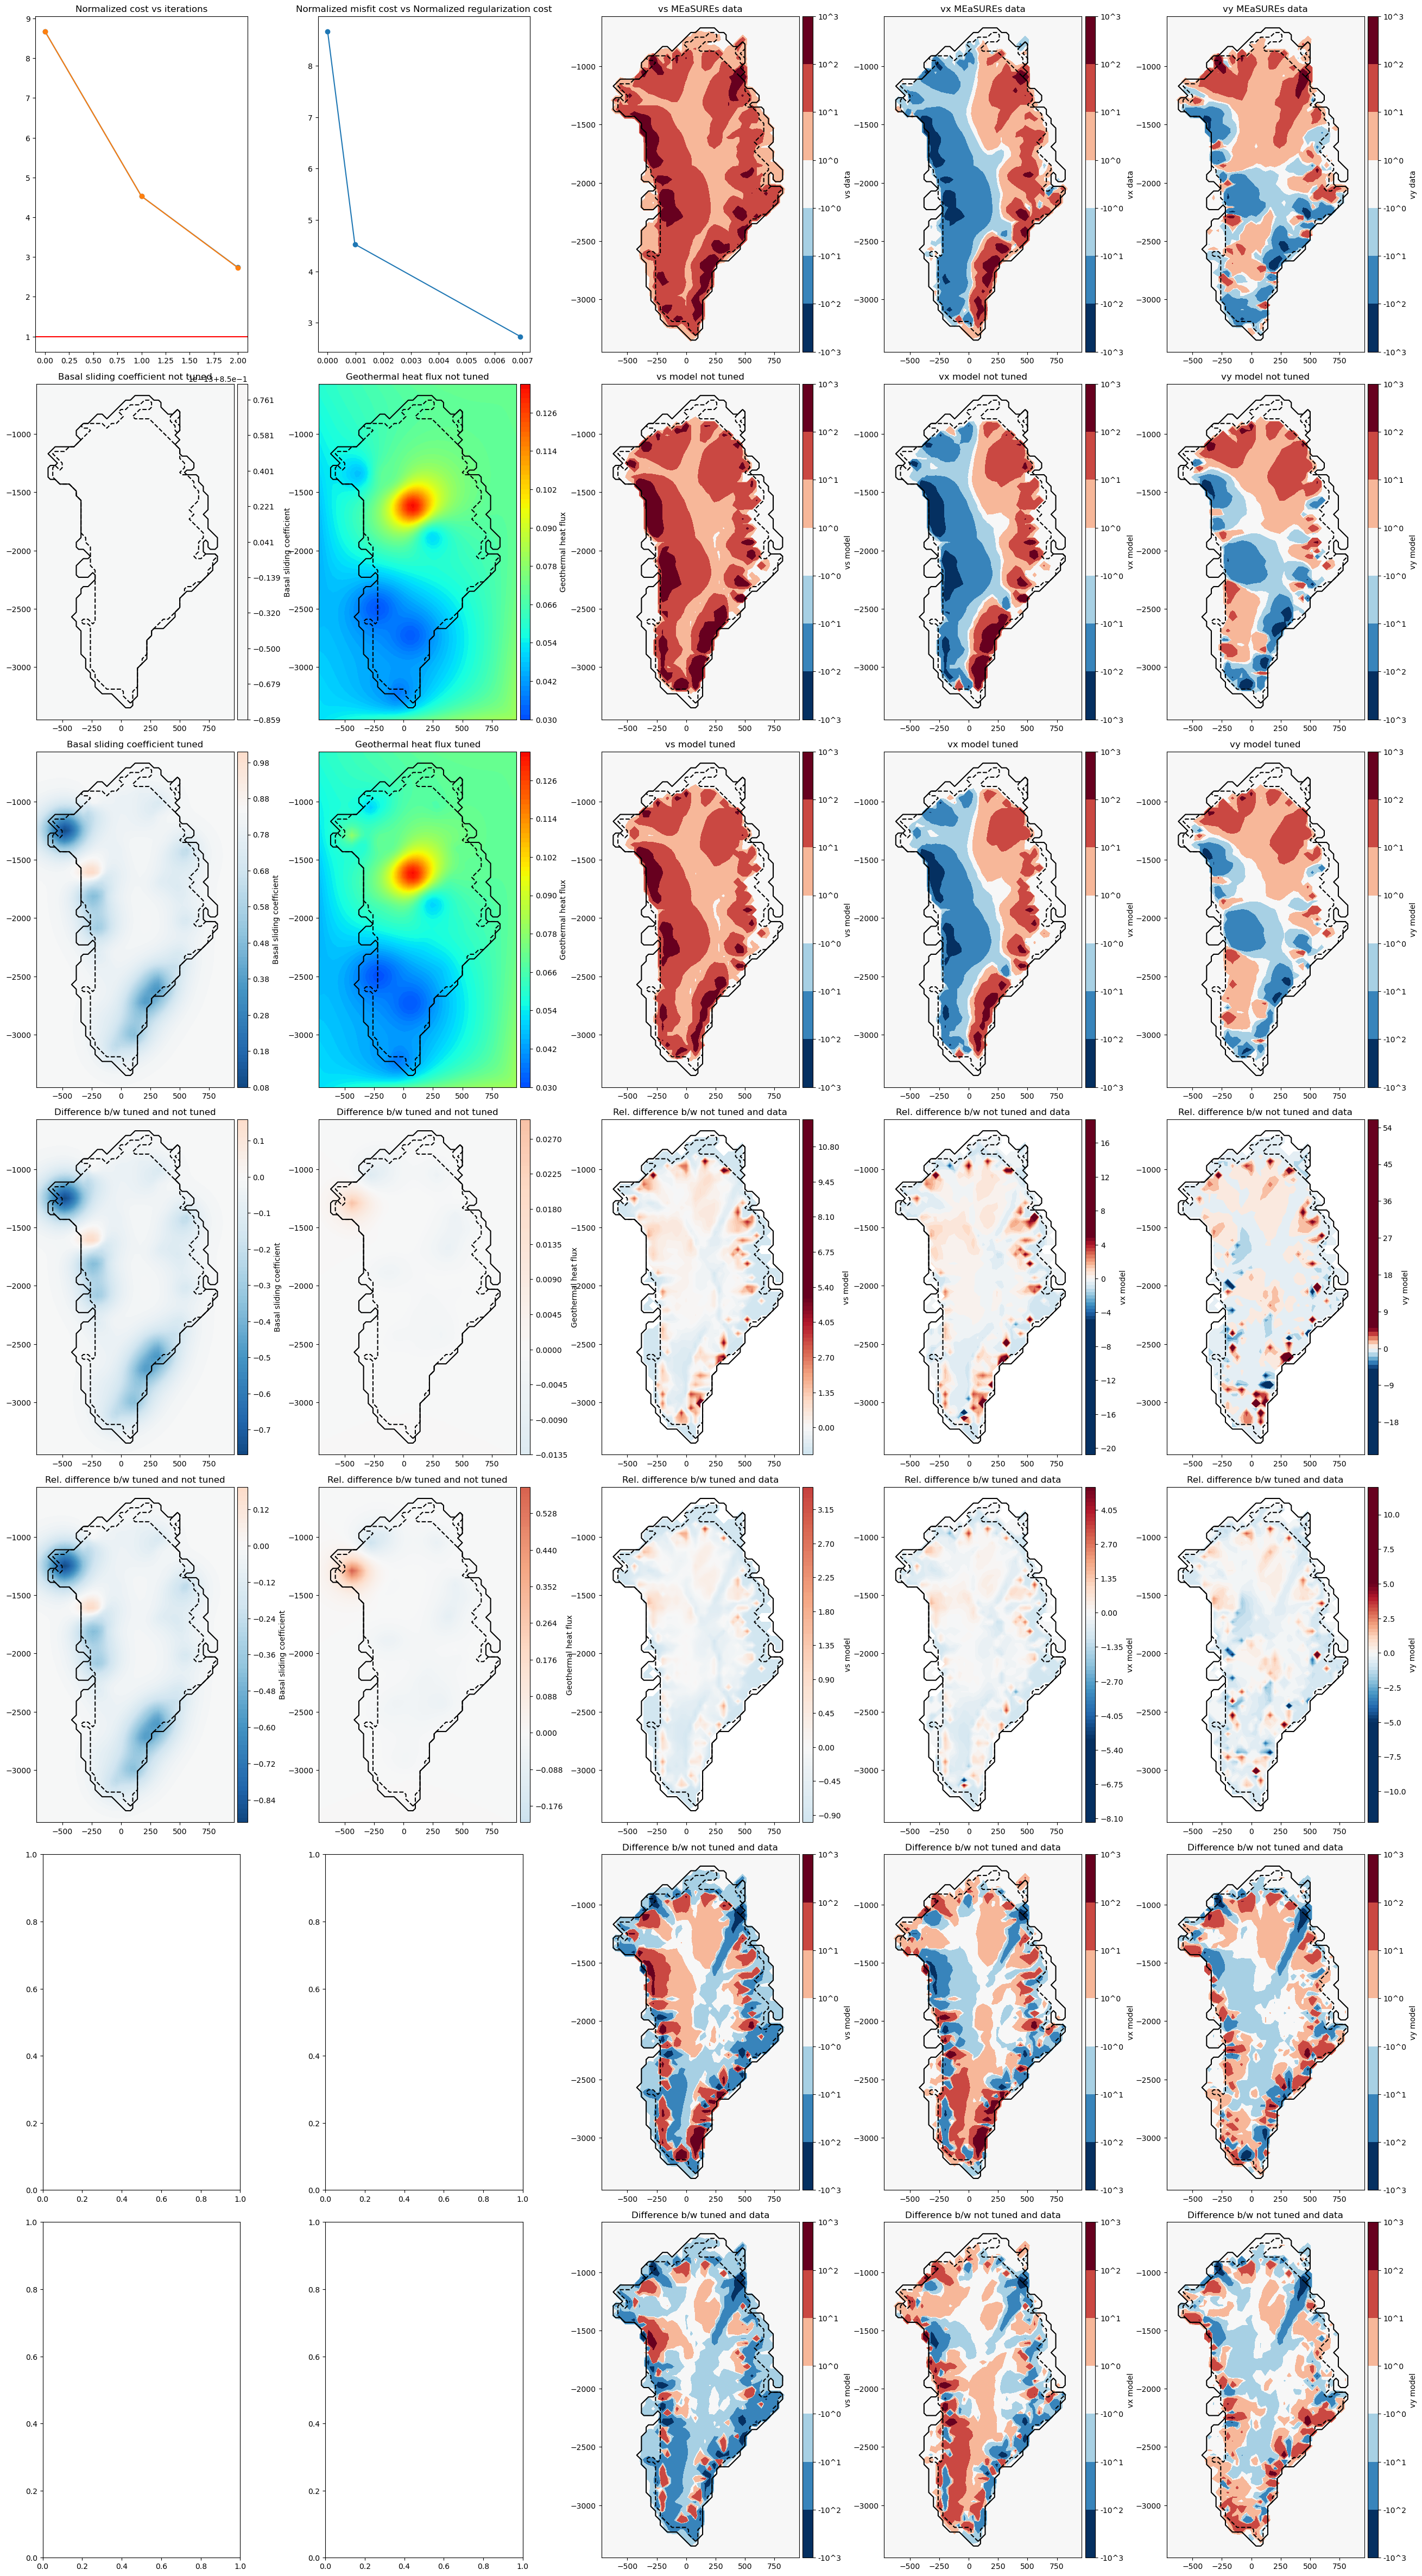

In [10]:
try:
    plotting("3point5", "_50_new", 2)
except:
    pass

MEAN
0.666579708632735 0.8945715763397264 1.8443565188522428
1.0367045561147665 1.167044143477578 2.361188173309903
0.28332370932918444 0.5662163653690204 1.5104991662637528
0.5697334332009206 0.6321446429809063 0.9360104918976615
0.9731310858514033 0.9740419620031475 1.005137981068045
0.46934021016797334 0.5700360671695103 1.0170374077605917
MAX
11.720779055118513 20.68844243699896 358.72434471052736
11.720779055118513 18.5272951986747 358.72434471052736
0.979677165874167 7.319651667654368 56.87814805354192
1.8547907933947485 7.6586768569896435 28.97306534324808
1.311387596901783 2.467728597313774 5.3524491523758675
0.9950029326525546 3.611635764744411 28.97306534324808
SCALARS
0.02787923582842544 -0.03832738055642193 -0.1372029477791128 -0.00773665622313513 0.1713745698149709


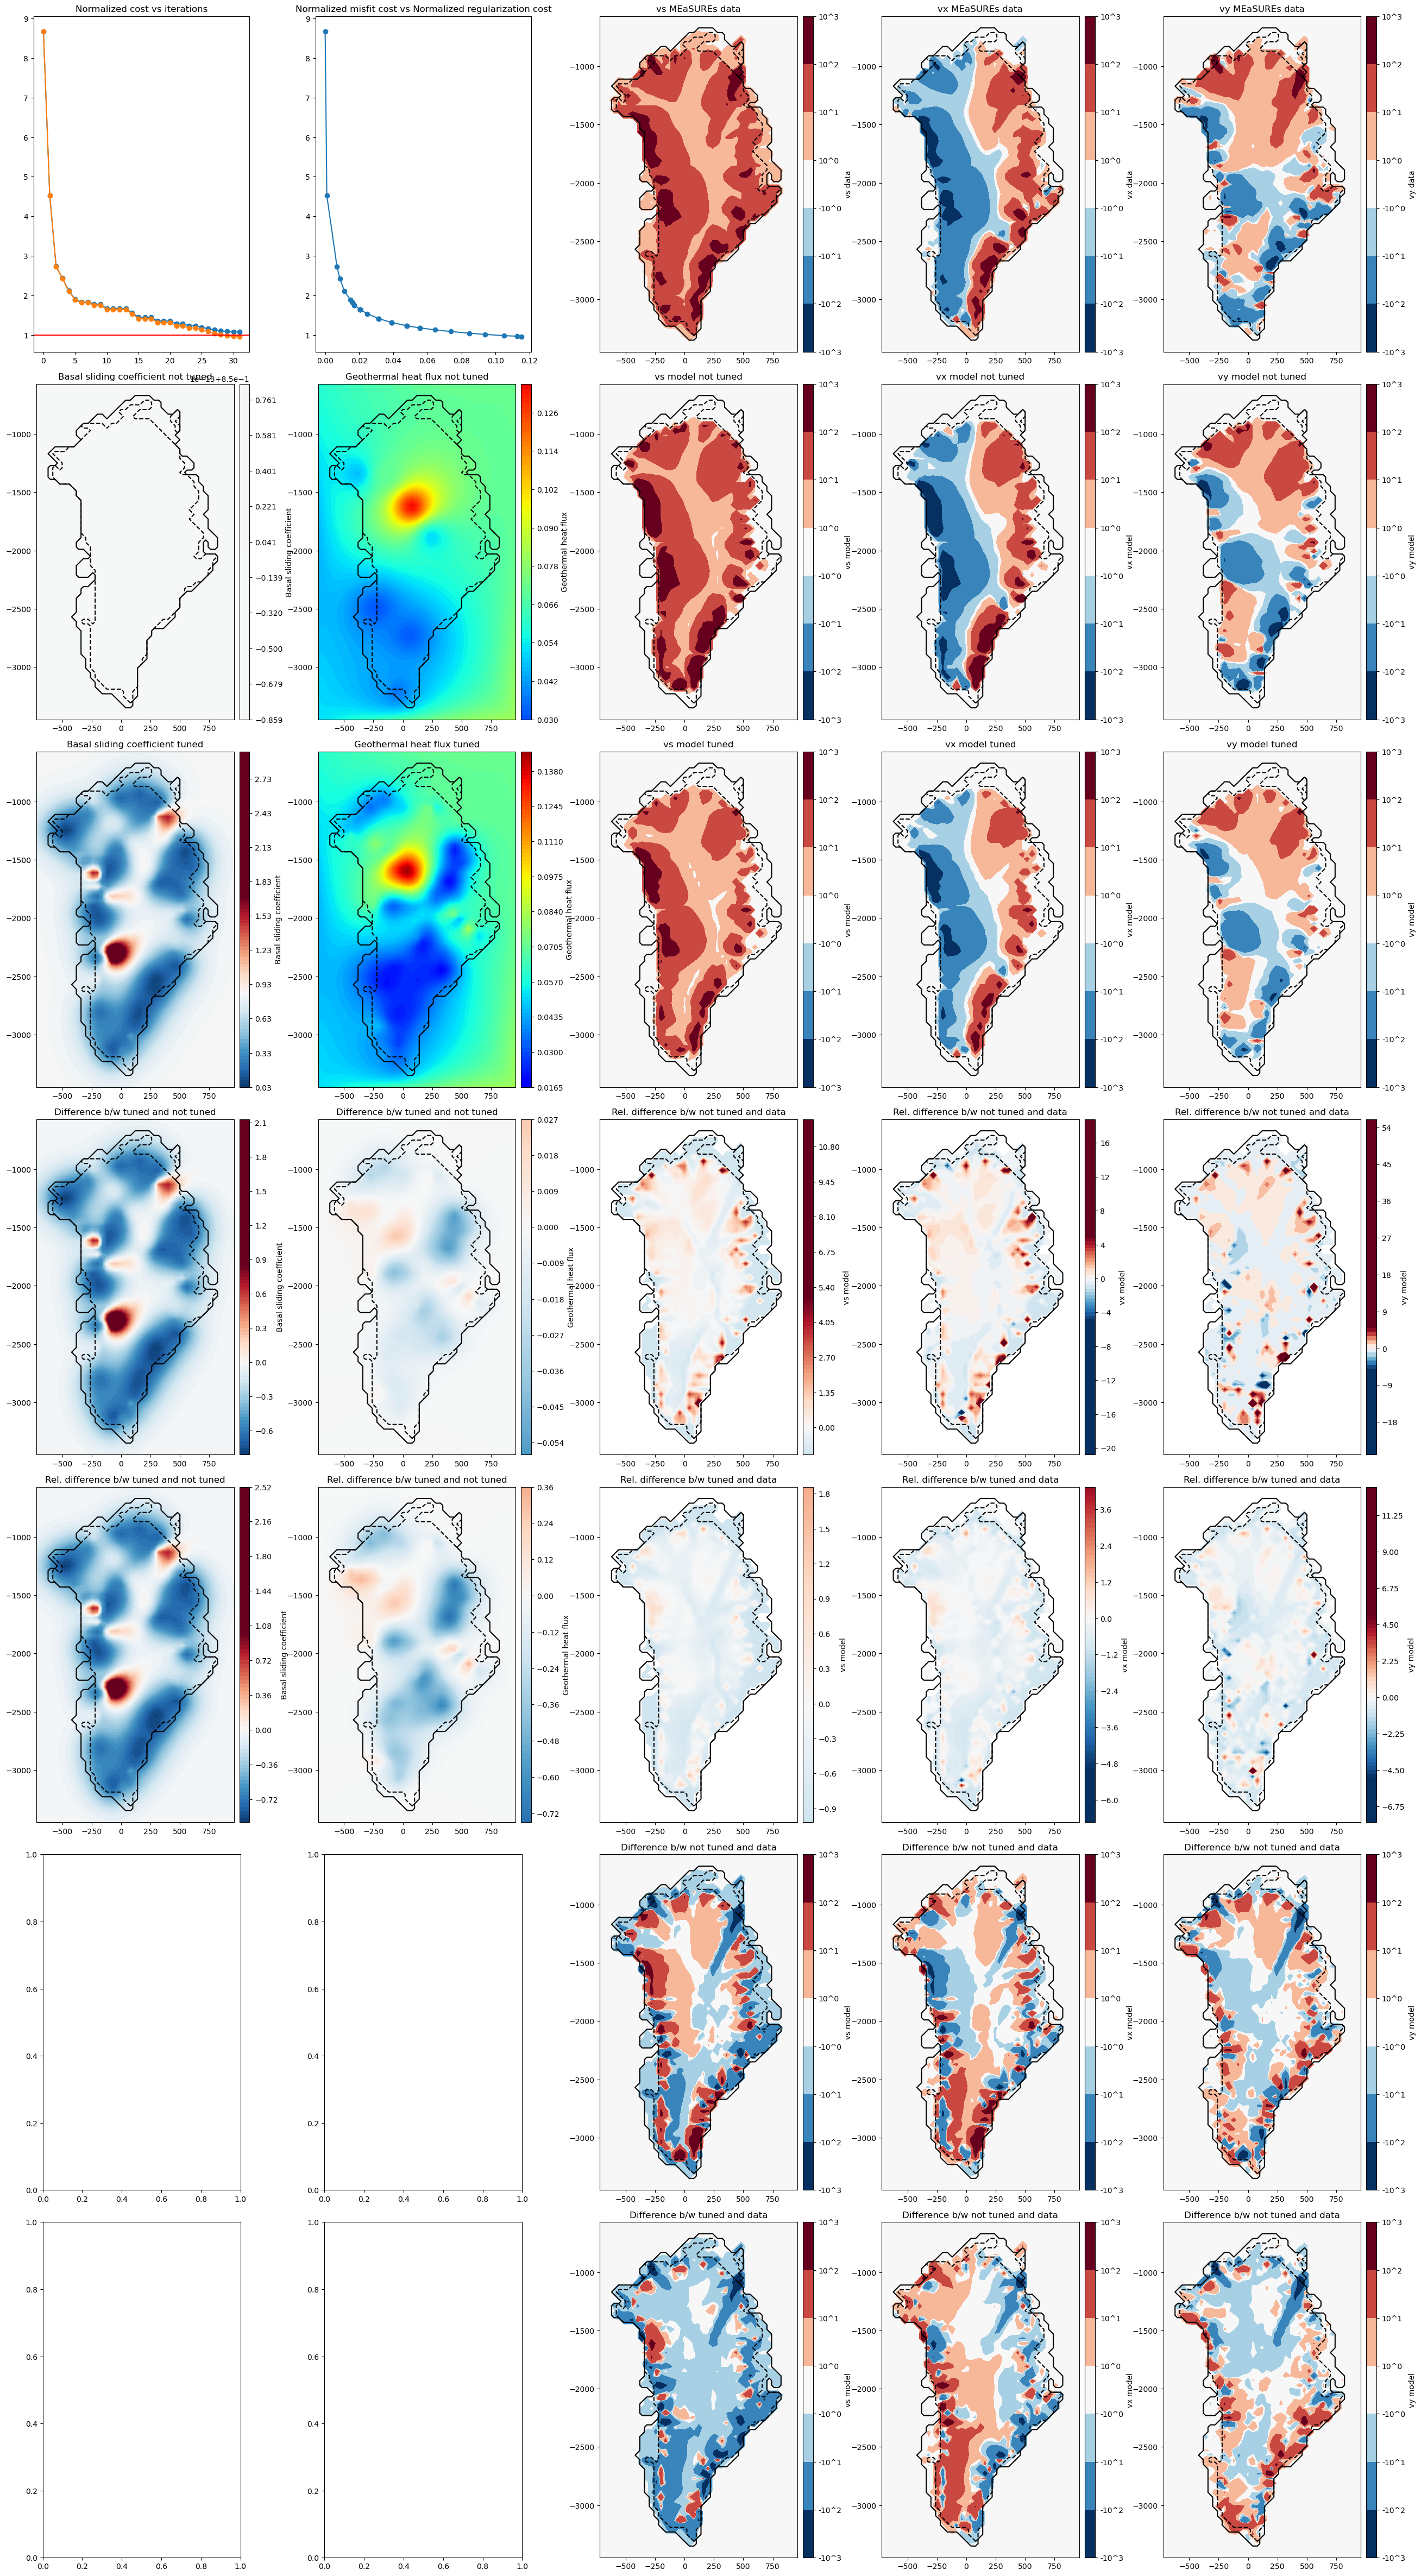

In [11]:
try:
    plotting("3point5", "_50_new_pickup", 29, True, 2)
except:
    pass

MEAN
0.666579708632735 0.8945715763397264 1.8443565188522428
1.0367045561147665 1.167044143477578 2.361188173309903
0.28332370932918444 0.5662163653690204 1.5104991662637528
0.5726876173722344 0.6297882770498607 0.9108875523017426
0.9711332320236721 0.9728615277871955 1.0021894232260613
0.4799857814357387 0.5727179553738779 0.9839641315331261
MAX
11.720779055118513 20.68844243699896 358.72434471052736
11.720779055118513 18.5272951986747 358.72434471052736
0.979677165874167 7.319651667654368 56.87814805354192
1.6542187398458181 7.32324376634945 27.59853703724631
1.0229070012136088 2.030955639725227 4.983436909674049
0.9954640442213979 3.435833968259544 27.59853703724631
SCALARS
0.024792333550121448 -0.04254627140110545 -0.1620162576977845 -0.008876114109787725 0.18644939387603254


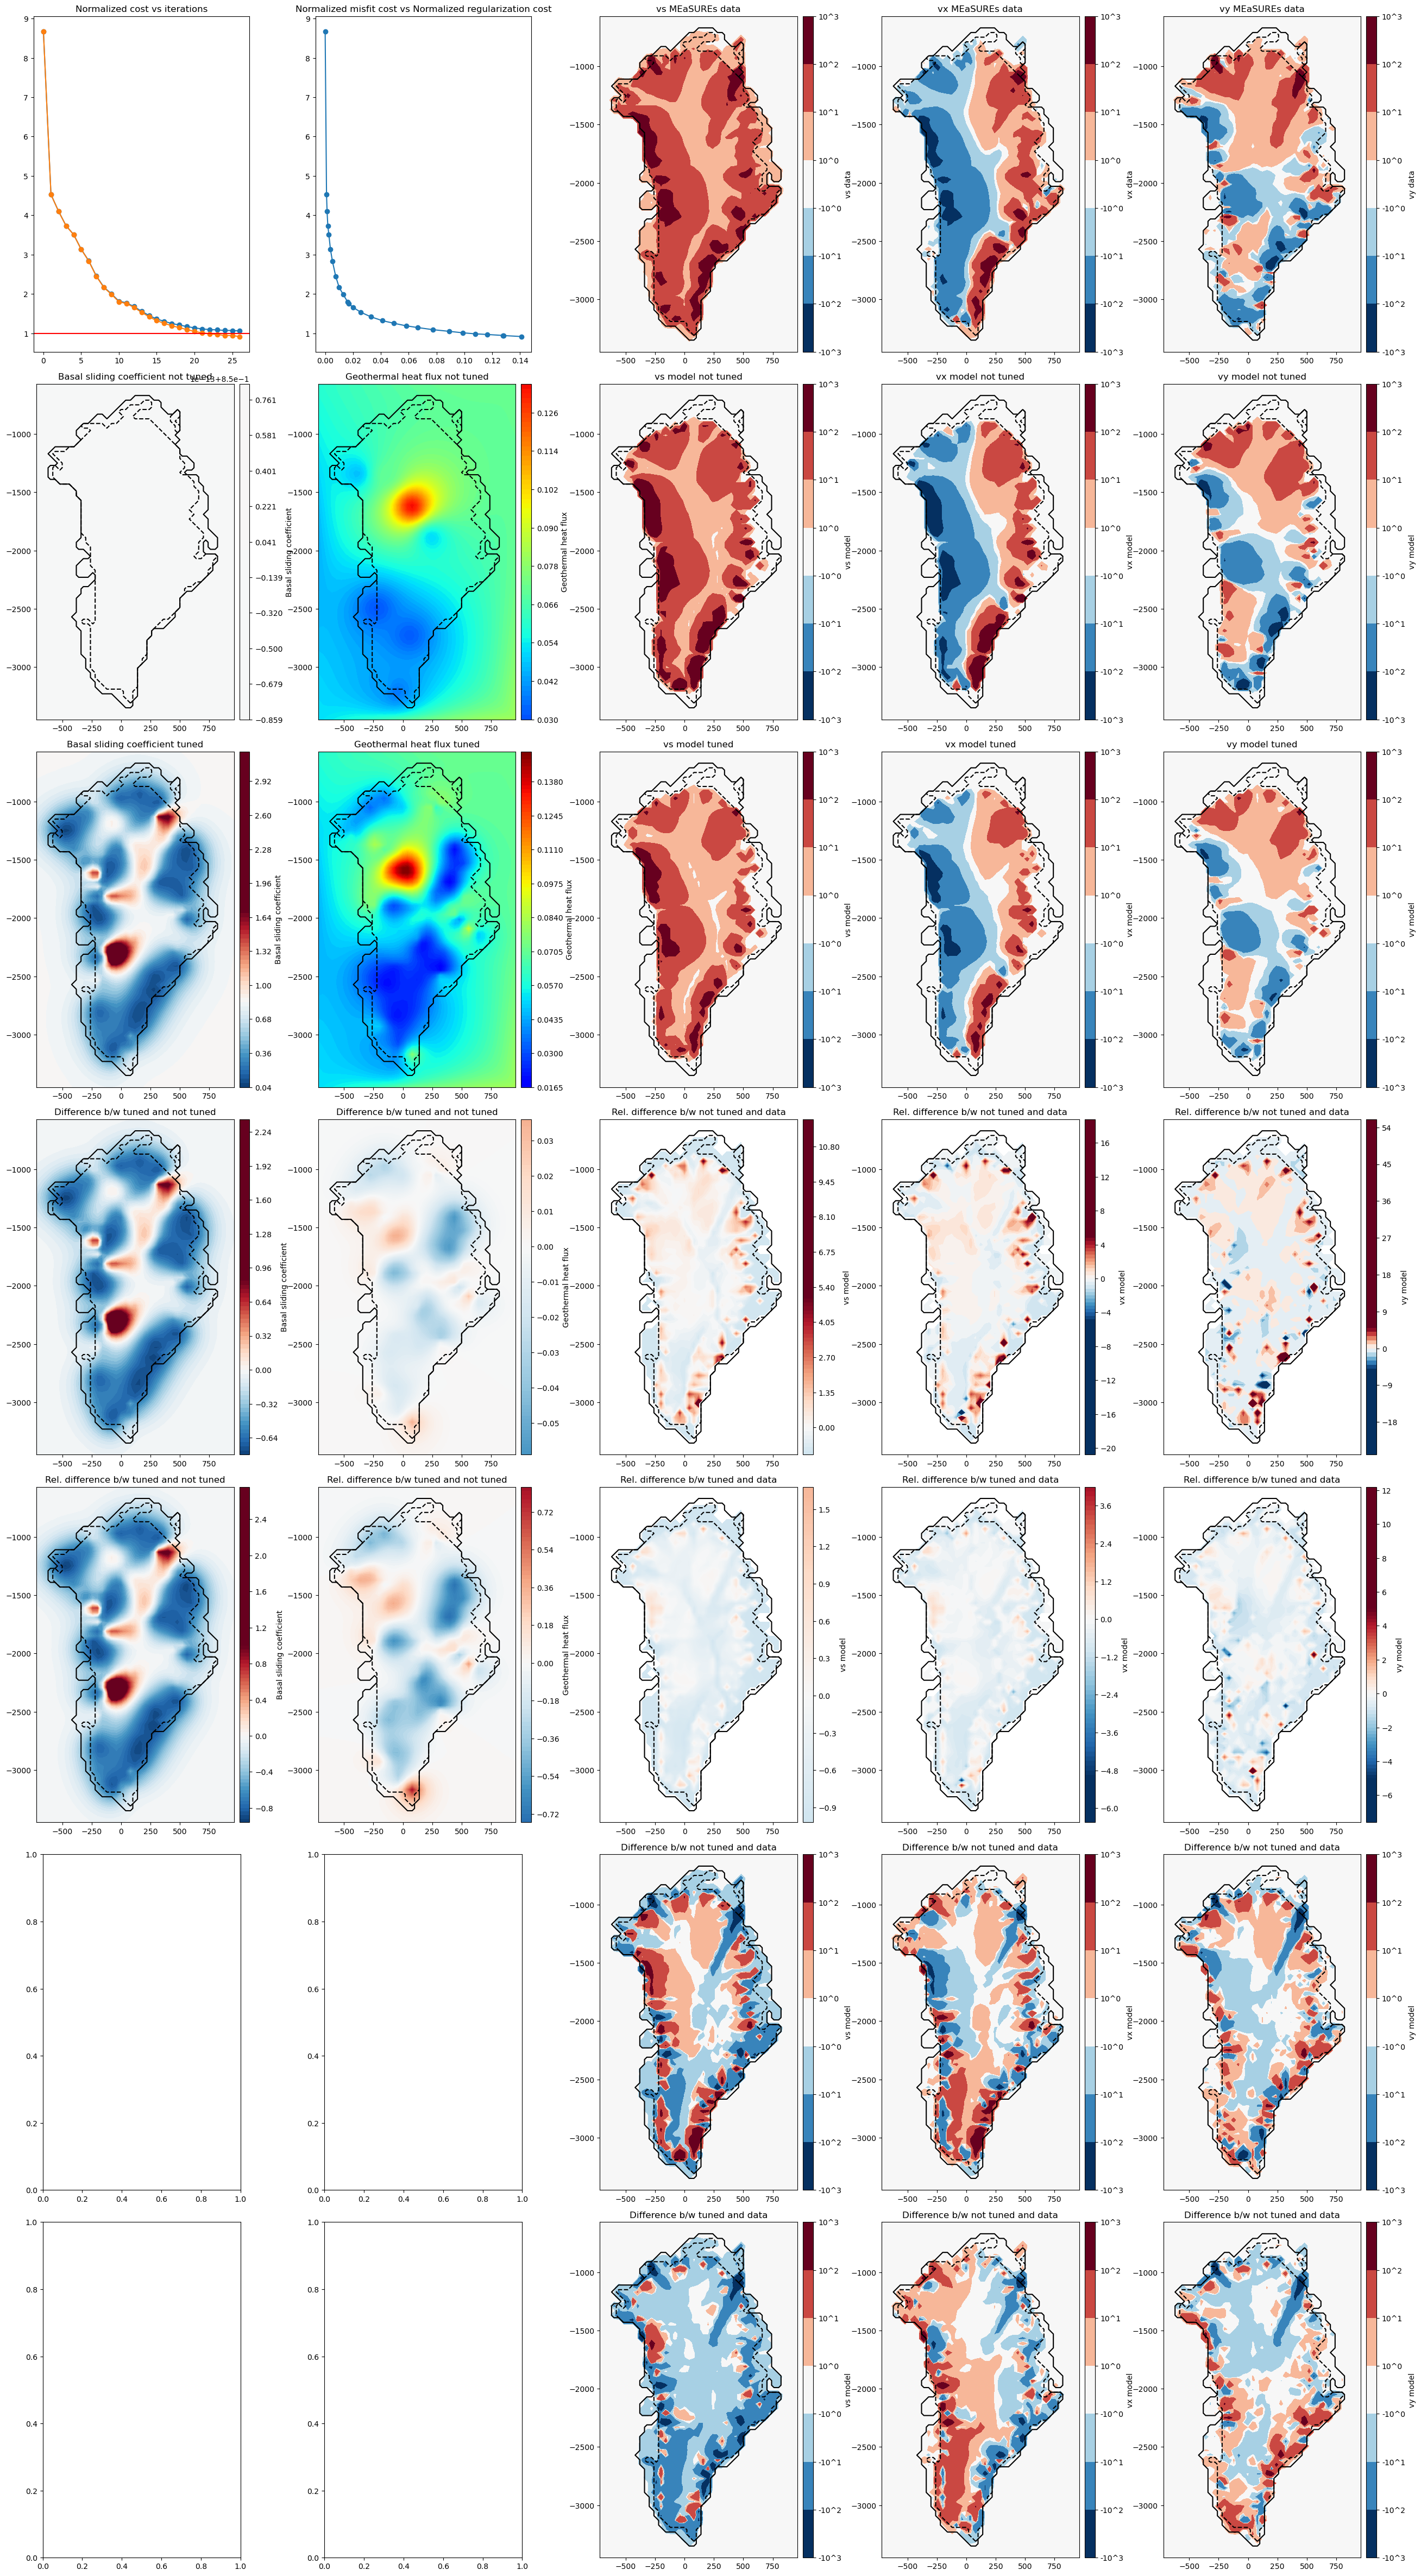

In [12]:
try:
    plotting("3point5", "_50_new_pickup_2", 25, True, 1, 9)
except:
    pass